# Final Project
- Topic : Effect of the Minimum Wage on Employment of Teenagers in the United States

## Contents

- 1. Data
    - 1-1. Descriptive statistics
    - 1-2. Visualization
- 2. Model
    - 2-1 Presence of fixed effects
    - 2-2 Variable selection (inschool)
    - 2-3 Variable selection (market)
- 3. Results
    - 3-1. Estimation by age group
    - 3-2. Estimates by gender and race

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## 1. Data

In [2]:
df = pd.read_excel('teen_employment.xlsx')

In [3]:
df.head()

,year,state,workft,workpt,employed,emp_rest,emp_rest_pt,emp_rest_ft,emp_retail,emp_retail_ft,...,workftmin,workptmin,employedmin,emp_restmin,emp_rest_ptmin,emp_rest_ftmin,emp_retailmin,emp_retail_ftmin,emp_retail_ptmin,inschoolmin
0,1990,1,0.132765,0.208400,0.341165,0.120739,0.069231,0.051508,0.184516,0.078681,...,0.041683,0.175115,0.216797,0.150457,0.150457,0.000000,0.150457,0.000000,0.150457,0.841130
1,1991,1,0.101886,0.219785,0.321671,0.076708,0.060223,0.016485,0.152656,0.036284,...,0.056753,0.180128,0.236880,0.043950,0.043950,0.000000,0.126053,0.000000,0.126053,0.811294
2,1992,1,0.103357,0.206009,0.309366,0.091669,0.062027,0.029641,0.179134,0.046905,...,0.119909,0.225128,0.345037,0.088534,0.057653,0.030881,0.225488,0.075039,0.150448,0.695461
3,1993,1,0.075959,0.267004,0.342963,0.078949,0.062745,0.016204,0.170524,0.024870,...,0.022453,0.169056,0.191509,0.081287,0.081287,0.000000,0.096520,0.000000,0.096520,0.871674
4,1994,1,0.103731,0.172641,0.276372,0.110523,0.051927,0.058596,0.166627,0.074707,...,0.047672,0.141970,0.189641,0.121445,0.073773,0.047672,0.158584,0.047672,0.110912,0.860456


In [4]:
## 변수 추가 
# real wage
df['realmw'] = df['minwage']/(df['cpi']/100)
# 최저임금 완벽하게 적용될만한 retail pt & rest pt 비율의 합
df['retail_rest'] = df['emp_rest'] + df['emp_retail']
df['retail_rest_ratio'] = df['retail_rest']/df['employed']  # 1이 넘는다?
df['lminwage'] = np.log(df['minwage'])

# retail, rest 비율 
df['rest_ratio']= df['emp_rest']/df['employed']
df['retail_ratio'] = df['emp_retail']/df['employed']

# 3분위수 초과 
df['rest'] = df['rest_ratio'].apply(lambda x : 1 if x > 0.33 else 0)
df['retail'] = df['retail_ratio'].apply(lambda x : 1 if x > 0.60 else 0)

# 시장 구조 (노동시장의 독점적 구조 정도)
df['market'] = df['rest']+df['retail']
df['market'] = pd.Categorical(df['market'])

## 1-1. Descriptive statistics

In [5]:
df[['minwage','employed','employed1617','employed1819','employedm',
    'employedf','employedmin','employedw','inschool','rest_ratio','retail_ratio']].describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
minwage,1224.0,5.52,1.28,3.35,4.25,5.15,6.75,9.19
employed,1224.0,0.36,0.10,0.05,0.30,0.37,0.43,0.68
employed1617,1224.0,0.27,0.11,0.01,0.19,0.26,0.34,0.64
employed1819,1224.0,0.47,0.11,0.07,0.40,0.47,0.54,0.82
employedm,1224.0,0.35,0.11,0.00,0.28,0.35,0.43,0.72
employedf,1224.0,0.38,0.11,0.01,0.30,0.37,0.45,0.74
employedmin,1218.0,0.27,0.12,0.00,0.20,0.26,0.34,1.00
employedw,1224.0,0.40,0.11,0.00,0.33,0.40,0.47,0.71
inschool,1224.0,0.81,0.05,0.61,0.77,0.81,0.85,0.95
rest_ratio,1224.0,0.27,0.08,0.00,0.22,0.27,0.33,0.71


## 1-2. Visualization

In [6]:
grouping = df[['state','minwage','realmw']].groupby(['state']).mean().reset_index()

In [7]:
# make group label 
# high : above real mw 3.2
# low : above real mw 2.92 
grouping['mwgroup'] = grouping.realmw.apply(lambda x : 'high' if x >= 3.2 else ('low' if x <= 2.92 else 'middle'))

In [8]:
df2 = pd.merge(df, grouping, on='state')

In [9]:
df2 = df2.drop(['realmw_x','minwage_y','realmw_y'], axis=1)

In [10]:
# split group 
low_group = df2[df2['mwgroup']=='low']
middle_group = df2[df2['mwgroup']=='middle']
high_group = df2[df2['mwgroup']=='high']

In [11]:
# minwage trend
# year trend on each group 
low_mw = low_group[['year','minwage_x']].groupby(['year']).mean().reset_index()
middle_mw = middle_group[['year','minwage_x']].groupby(['year']).mean().reset_index()
high_mw = high_group[['year','minwage_x']].groupby(['year']).mean().reset_index()

low_mw.columns = ['year','low_mw_ave']
middle_mw.columns = ['year','middle_mw_ave']
high_mw.columns = ['year', 'high_mw_ave']

grouped_mw = pd.merge(low_mw, middle_mw)
grouped_mw = pd.merge(grouped_mw, high_mw)
grouped_mw.head()

,year,low_mw_ave,middle_mw_ave,high_mw_ave
0,1990,3.352778,3.465217,3.980
1,1991,3.800000,3.843478,4.135
2,1992,4.250000,4.267391,4.372
3,1993,4.250000,4.302174,4.472
4,1994,4.250000,4.302174,4.637


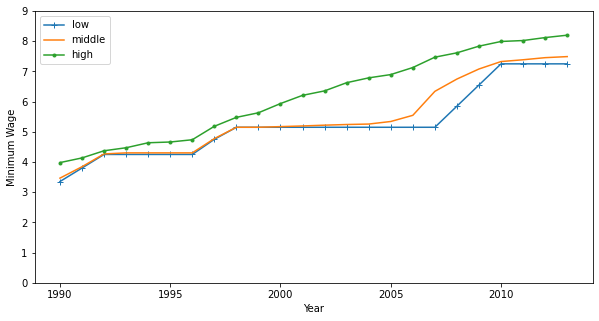

In [12]:
# visualizing 
plt.figure(figsize=(10,5))
plt.ylim([0,9])
plt.ylabel('Minimum Wage')
plt.xlabel('Year')
plt.plot(grouped_mw['year'], grouped_mw['low_mw_ave'], label='low', marker = '+')
plt.plot(grouped_mw['year'], grouped_mw['middle_mw_ave'], label='middle')
plt.plot(grouped_mw['year'], grouped_mw['high_mw_ave'], label='high', marker='.')
plt.legend()
plt.show()

### Interpretation

- low : 1, 13, 16, 18, 20, 21, 22, 28, 31, 38, 40, 45, 46, 47, 48, 49, 51, 56
- middle : 4,  5,  8, 10, 12, 17, 19, 23, 24, 26, 27, 29, 30, 32, 33, 34, 35, 36, 37, 39, 42, 54, 55
- high : 2,  6,  9, 11, 15, 25, 41, 44, 50, 53  


In all three groups, an upward trend can be seen over the entire period, the group of $3.2 or more showed a continuous upward trend over the entire period, and the other two groups are similar in a cascade, but it can be seen that there is a difference after 2000

In [13]:
# year trend on each group 
low_emp = low_group[['year','employed']].groupby(['year']).mean().reset_index()
middle_emp = middle_group[['year','employed']].groupby(['year']).mean().reset_index()
high_emp = high_group[['year','employed']].groupby(['year']).mean().reset_index()

low_emp.columns = ['year','low_emp_ave']
middle_emp.columns = ['year','middle_emp_ave']
high_emp.columns = ['year', 'high_emp_ave']

grouped_emp = pd.merge(low_emp, middle_emp)
grouped_emp = pd.merge(grouped_emp, high_emp)
grouped_emp.head()

,year,low_emp_ave,middle_emp_ave,high_emp_ave
0,1990,0.430530,0.440982,0.426007
1,1991,0.426991,0.397643,0.384820
2,1992,0.366651,0.377553,0.354944
3,1993,0.388337,0.386950,0.332825
4,1994,0.419809,0.403337,0.334056


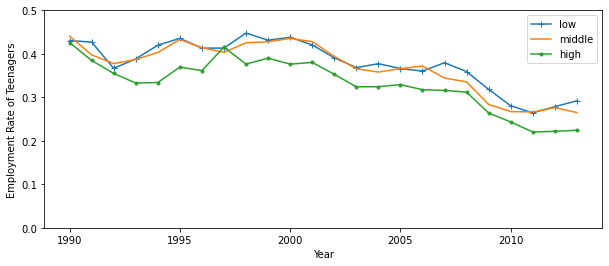

In [14]:
# visualizing 
plt.figure(figsize=(10,4))
plt.ylim([0,0.5])
plt.ylabel('Employment Rate of Teenagers')
plt.xlabel('Year')
plt.plot(grouped_emp['year'], grouped_emp['low_emp_ave'], label='low', marker = '+')
plt.plot(grouped_emp['year'], grouped_emp['middle_emp_ave'], label='middle')
plt.plot(grouped_emp['year'], grouped_emp['high_emp_ave'], label='high', marker='.')
plt.legend()
plt.show()

### Interpretation

- low : 1, 13, 16, 18, 20, 21, 22, 28, 31, 38, 40, 45, 46, 47, 48, 49, 51, 56
- middle : 4,  5,  8, 10, 12, 17, 19, 23, 24, 26, 27, 29, 30, 32, 33, 34, 35, 36, 37, 39, 42, 54, 55
- high : 2,  6,  9, 11, 15, 25, 41, 44, 50, 53

- This figure shows the trends in the employment rate of 16-19 year olds by group. All three groups show a similar trend, declining until the mid-90s, after that, rising until the 2000s, then decreasing until 2010, and then slightly rising thereafter. From the downward trend, I can guess the collapse of the dot-com bubble in the early 2000s and the financial crisis of 2009. As such, it can be seen that the employment rate data reflects the economy over time. Looking at each group, the employment rate of the 3.2 dollors or more group was lower than that of other groups overall, and the group under 2.92 dollors and the in-between group were overall similar, but there was a slight gap after the mid-2000s.

In [15]:
# retail rest ratio trend
# year trend on each group 
low_retail = low_group[['year','retail_ratio']].groupby(['year']).mean().reset_index()
middle_retail = middle_group[['year','retail_ratio']].groupby(['year']).mean().reset_index()
high_retail = high_group[['year','retail_ratio']].groupby(['year']).mean().reset_index()

low_retail.columns = ['year','low_retail']
middle_retail.columns = ['year','middle_retail']
high_retail.columns = ['year', 'high_retail']

grouped_retail = pd.merge(low_retail, middle_retail)
grouped_retail = pd.merge(grouped_retail, high_retail)
grouped_retail.head()

,year,low_retail,middle_retail,high_retail
0,1990,0.500849,0.521462,0.511179
1,1991,0.501815,0.536222,0.511305
2,1992,0.516753,0.530101,0.504864
3,1993,0.516633,0.503095,0.556025
4,1994,0.530779,0.515584,0.519537


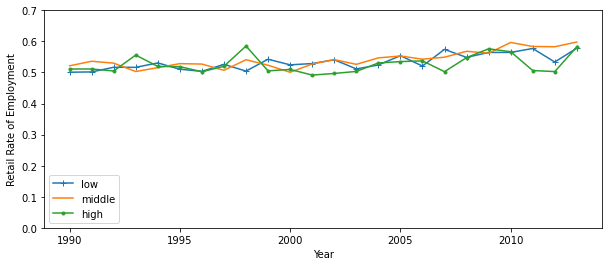

In [16]:
# visualizing 
plt.figure(figsize=(10,4))
plt.xlabel('Year')
plt.ylabel('Retail Rate of Employment')
plt.plot(grouped_retail['year'], grouped_retail['low_retail'], label='low', marker = '+')
plt.plot(grouped_retail['year'], grouped_retail['middle_retail'], label='middle')
plt.plot(grouped_retail['year'], grouped_retail['high_retail'], label='high', marker='.')
plt.ylim([0,0.7])
plt.legend()
plt.show()

### Interpretation
- There is no clear difference between groups, and it can be seen that they do not depend only on time trends.

## 2. Model

## 2-1 Presence of fixed effects

In [17]:
data = df[['year','state','employed','lminwage']]
data = data.set_index(['state','year'])
years = data.index.get_level_values('year').to_list()
data['year'] = pd.Categorical(years)

In [18]:
# Pooled OLS
from linearmodels.panel import PooledOLS
formula = 'employed ~ lminwage + 1'
model1 = PooledOLS.from_formula(formula = formula, data=data).fit()
model1

Dep. Variable:,employed,R-squared:,0.2355
Estimator:,PooledOLS,R-squared (Between):,0.0492
No. Observations:,1224,R-squared (Within):,0.4118
Date:,"Mon, Jun 20 2022",R-squared (Overall):,0.2355
Time:,18:49:37,Log-likelihood,1232.8
Cov. Estimator:,Unadjusted,,
,,F-statistic:,376.40
Entities:,51,P-value,0.0000
Avg Obs:,24.000,Distribution:,"F(1,1222)"
Min Obs:,24.000,,
Max Obs:,24.000,F-statistic (robust):,376.40


In [19]:
# Panel OLS 
from linearmodels.panel import PanelOLS

formula = 'employed ~ lminwage + EntityEffects + 1'
model2 = PanelOLS.from_formula(formula = formula, data=data).fit(cov_type='robust')
model2

Dep. Variable:,employed,R-squared:,0.4119
Estimator:,PanelOLS,R-squared (Between):,0.0489
No. Observations:,1224,R-squared (Within):,0.4119
Date:,"Mon, Jun 20 2022",R-squared (Overall):,0.2354
Time:,18:49:37,Log-likelihood,1801.0
Cov. Estimator:,Robust,,
,,F-statistic:,820.97
Entities:,51,P-value,0.0000
Avg Obs:,24.000,Distribution:,"F(1,1172)"
Min Obs:,24.000,,
Max Obs:,24.000,F-statistic (robust):,801.10


In [20]:
formula = 'employed ~ lminwage +TimeEffects+1'
model3 = PanelOLS.from_formula(formula = formula, data=data).fit(cov_type='robust')
model3

Dep. Variable:,employed,R-squared:,0.0285
Estimator:,PanelOLS,R-squared (Between):,0.0455
No. Observations:,1224,R-squared (Within):,0.4021
Date:,"Mon, Jun 20 2022",R-squared (Overall):,0.2287
Time:,18:49:37,Log-likelihood,1307.8
Cov. Estimator:,Robust,,
,,F-statistic:,35.127
Entities:,51,P-value,0.0000
Avg Obs:,24.000,Distribution:,"F(1,1199)"
Min Obs:,24.000,,
Max Obs:,24.000,F-statistic (robust):,37.029


In [21]:
formula = 'employed ~ lminwage + EntityEffects+TimeEffects+1'
model4 = PanelOLS.from_formula(formula = formula, data=data).fit(cov_type='robust')
model4

Dep. Variable:,employed,R-squared:,0.0055
Estimator:,PanelOLS,R-squared (Between):,0.0220
No. Observations:,1224,R-squared (Within):,0.2156
Date:,"Mon, Jun 20 2022",R-squared (Overall):,0.1214
Time:,18:49:37,Log-likelihood,2027.1
Cov. Estimator:,Robust,,
,,F-statistic:,6.4098
Entities:,51,P-value,0.0115
Avg Obs:,24.000,Distribution:,"F(1,1149)"
Min Obs:,24.000,,
Max Obs:,24.000,F-statistic (robust):,6.8317


In [22]:
# 모델 비교 
from linearmodels.panel import compare

compare({'Pooled OLS':model1, 'State Effect':model2, 'Time Effect':model3, 'State & Time Effect':model4})

,Pooled OLS,State Effect,Time Effect,State & Time Effect
Dep. Variable,employed,employed,employed,employed
Estimator,PooledOLS,PanelOLS,PanelOLS,PanelOLS
No. Observations,1224,1224,1224,1224
Cov. Est.,Unadjusted,Robust,Robust,Robust
R-squared,0.2355,0.4119,0.0285,0.0055
R-Squared (Within),0.4118,0.4119,0.4021,0.2156
R-Squared (Between),0.0492,0.0489,0.0455,0.0220
R-Squared (Overall),0.2355,0.2354,0.2287,0.1214
F-statistic,376.40,820.97,35.127,6.4098
P-value (F-stat),0.0000,0.0000,0.0000,0.0115


### Interpretation
- If there is no effect, the coefficient is -0.2147.
- When there is only state effect, the coefficient decreases from -0.2147 to -0.2109.
- When there is only Year effect, the coefficient decreases from -0.2147 to -0.1783.
- When both state effects and year effects are present, the coefficient decreases from -0.2147 to -0.0653.

## 2-2. Variable selection (Inschool)
- Endogenous between the employment rate and the minimum wage variable

## Endogenous between the employment rate and the minimum wage variable

In [23]:
df2 = df[['year','state','employed','minwage','inschool','market']]

In [24]:
# 인근 주 정리
# 1 (앨라바마) : 미시시피,테네시,조지아,플로리다 (28,47,13,12)
# 2 (알라스카) : -
# 4 (애리조나) : 캘리포니아, 네바다, 유타, 콜로라도, 뉴멕시코 (6,32,49,8,35)
# 5 (아칸소) : 오클라호바,미주리,테네시,미시시피,루이지애나 (40,29,47,28,22)
# 6 (켈리포니아) : 오리건, 네바다,에리조나 (41,31,4)
# 8 (콜로라도) : 유타,와이오밍,네브래스카,캔자스,뉴멕시코 (49,56,31,20,35)
# 9 (코네티컷) : 뉴욕,메사추세츠,로드아일랜드 (36,25,44)
# 10 (델라웨어) : 메릴렌드 (24)
# 11 (워싱턴DC, 콜롬비아 지구) : 팬실베니아, 버지니아, 웨스트버지니아 (42,51,54)
# 12 (플로리다) : 조지아, 엘라바마 (13, 1)
# 13 (조지아) : 엘라바마, 테네시, 노스케롤라이나, 사우스케롤라이나, 플로리다 (1,47,37,45,12)
# 15 (하와이) : - 
# 16 (아이다호) : 오리건, 워싱턴, 몬테나, 와이오밍, 유타, 네바다 (41, 53, 30, 56, 49, 32)
# 17 (일리노이) : 아이오와, 위스콘신, 인디애나, 켄터키, 미주리 (19,55,18,21,29)
# 18 (인디애나) : 일리노이, 미시간,오하이오,켄터키(17,26,39,21)
# 19 (아이오와) : 사우스다코타, 미네소타, 위스콘신, 일리노이, 미주리, 네브레스카 (46,27,55,17,29,31)
# 20 (캔자스) : 콜로라도, 네브레스카, 미주리, 오클라호마 (8,31,29,40)
# 21 (캔터키) : 일리노이,인디애나,오하이오,사우스케롤라이나,버지니아,테네시(17,18,39,45,51,47)
# 22 (루이지애나) : 텍사스,아칸소,미시시피 (48,5,28)
# 23 (메인) : 버몬트, 뉴햄프셔 (50,33)
# 24 (메릴랜드) : 델라웨어 (10)
# 25 (메사추세츠) : 뉴욕, 버몬트, 뉴햄프셔, 로드아일랜드 (36,50,33,44)
# 26 (미시간) : 인디애나, 오하이오 (18,39)
# 27 (미네소타) : 노스다코타, 사우스다코타, 아이오와, 위스콘신 (38,46,19,55)
# 28 (미시시피) : 아칸소,테네시,앨라바마,루이지애나 (5,47,1,22)
# 29 (미주리): 캔자스, 아이오와, 일리노이, 아칸소 (20,19,17,5)
# 30 (몬타나):아이다호,와이오밍,노스다코타,사우스다코타(16,56,38,46)
# 31 (네브레스카):와이오밍,사우스다코타,아이오와,캔자스,콜로라도(56,46,19,20,8)
# 32 (네바다):캘리포니아,오리건,아이다호,유타,애리조나(6,41,16,49,4)
# 33 (뉴햄프셔):버몬트,메인,메사추세츠 (50,23,25)
# 34 (뉴저지):펜실베니아,뉴욕(42,36)
# 35 (뉴멕시코) :애리조나,콜로라도,텍사스(4,8,48)
# 36 (뉴욕) : 버몬트,메사추세츠,코네티컷,펜실베니아(50,25,9,42)
# 37 (노스케롤라이나) :버지니아,테네시,사우스케롤라이나(51,47,45)
# 38 (노스다코타):몬테나,사우스다코타,미네소타(30,46,27)
# 39 (오하이오):인디애나, 미시간,펜실베니아,웨스트버지니아,캔터키(18,26,42,54,21)
# 40 (오클라호마):켄자스,텍사스,아칸소(20,48,5)
# 41 (오리건):워싱턴,아이다호,네바다,캘리포니아(53,16,32,6)
# 42 (펜실베니아):오하이오,뉴욕,뉴저지,콜롬비아지구(39,36,34,11)
# 44 (로드아일랜드):코네티컷,매사추세츠(9,25)
# 45 (사우스케롤라이나):조지아,노스케롤라이나(13,37)
# 46 (사우스다코타):몬테나,와이오밍,노스다코타,미네소타,네브레스카(30,56,38,27,31)
# 47 (테네시):켄터키,노스케롤라이나,조지아,앨라바마,미시시피(21,37,13,1,28)
# 48 (텍사스):뉴멕시코,오클라호마,아칸소,루이지애나(35,40,5,22)
# 49 (유타):네바다,아이다호,와이오밍,콜로라도,애리조나(32,16,56,8,4)
# 50 (버몬트):뉴욕,뉴햄프셔,매사추세츠(36,33,25)
# 51 (버지니아):웨스트버지니아,콜롬비아지구,노스케롤라이나(54,11,37)
# 53 (워싱턴):오리건,아이다호(41,16)
# 54 (웨스트버지니아):오하이오,펜실베니아,버지니아,켄터키(39,42,51,21)
# 55 (위스콘신):미네소타,아이오와,일리노이(27,19,17)
# 56 (와이오밍):아이다호,몬테나,사우스다코타,네브레스카,콜로라도,유타(16,30,46,31,8,49)

In [25]:
# 함수1 , 평균만들어 주는 함수
def makenearwage(df, col, *args):
    nearwages = []
    length=len(*args)
    for i in args:
        nearwage = df.loc[i,col]
        nearwages.append(nearwage)
    return sum(sum(nearwages))/length

In [26]:
# 함수2, 주별로 인근주 최저임금 만들어주는 함수
def makeInstrument(df):
    
    # 1 (앨라바마) : 미시시피,테네시,조지아,플로리다 (28,47,13,12)
    df.loc[1,'nearminwage'] = makenearwage(df,'minwage',[28,47,13,12])
    # 4 (애리조나) : 캘리포니아, 네바다, 유타, 콜로라도, 뉴멕시코 (6,32,49,8,35)
    df.loc[4,'nearminwage'] = makenearwage(df,'minwage',[6,32,49,8,35])
    # 5 (아칸소) : 오클라호바,미주리,테네시,미시시피,루이지애나 (40,29,47,28,22)
    df.loc[5,'nearminwage'] = makenearwage(df,'minwage',[40,29,47,28,22])
    # 6 (켈리포니아) : 오리건, 네바다,에리조나 (41,31,4)
    df.loc[6,'nearminwage'] = makenearwage(df,'minwage',[41,31,4])
    # 8 (콜로라도) : 유타,와이오밍,네브래스카,캔자스,뉴멕시코 (49,56,31,20,35)
    df.loc[8,'nearminwage'] = makenearwage(df,'minwage',[49,56,31,20,35])
    # 9 (코네티컷) : 뉴욕,메사추세츠,로드아일랜드 (36,25,44)
    df.loc[9,'nearminwage'] = makenearwage(df,'minwage',[36,25,44])
    # 10 (델라웨어) : 메릴렌드 (24)
    df.loc[10,'nearminwage'] = makenearwage(df,'minwage',[24])
    # 11 (워싱턴DC, 콜롬비아 지구) : 팬실베니아, 버지니아, 웨스트버지니아 (42,51,54)
    df.loc[11,'nearminwage'] = makenearwage(df,'minwage',[42,51,54])
    # 12 (플로리다) : 조지아, 엘라바마 (13, 1)
    df.loc[12,'nearminwage'] = makenearwage(df,'minwage',[13,1])
    # 13 (조지아) : 엘라바마, 테네시, 노스케롤라이나, 사우스케롤라이나, 플로리다 (1,47,37,45,12)
    df.loc[13,'nearminwage'] = makenearwage(df,'minwage',[1,47,37,45,1])
    # 15 (하와이) : - 
    # 16 (아이다호) : 오리건, 워싱턴, 몬테나, 와이오밍, 유타, 네바다 (41, 53, 30, 56, 49, 32)
    df.loc[16,'nearminwage'] = makenearwage(df,'minwage',[41, 53, 30, 56, 49, 32])
    # 17 (일리노이) : 아이오와, 위스콘신, 인디애나, 켄터키, 미주리 (19,55,18,21,29)
    df.loc[17,'nearminwage'] = makenearwage(df,'minwage',[19,55,18,21,29])
    # 18 (인디애나) : 일리노이, 미시간,오하이오,켄터키(17,26,39,21)
    df.loc[18,'nearminwage'] = makenearwage(df,'minwage',[17,26,39,21])
    # 19 (아이오와) : 사우스다코타, 미네소타, 위스콘신, 일리노이, 미주리, 네브레스카 (46,27,55,17,29,31)
    df.loc[19,'nearminwage'] = makenearwage(df,'minwage',[46,27,55,17,29,31])
    # 20 (캔자스) : 콜로라도, 네브레스카, 미주리, 오클라호마 (8,31,29,40)
    df.loc[20,'nearminwage'] = makenearwage(df,'minwage',[8,31,29,40])
    # 21 (캔터키) : 일리노이,인디애나,오하이오,사우스케롤라이나,버지니아,테네시(17,18,39,45,51,47)
    df.loc[21,'nearminwage'] = makenearwage(df,'minwage',[17,18,39,45,51,47])
    # 22 (루이지애나) : 텍사스,아칸소,미시시피 (48,5,28)
    df.loc[22,'nearminwage'] = makenearwage(df,'minwage',[48,5,28])
    # 23 (메인) : 버몬트, 뉴햄프셔 (50,33)
    df.loc[23,'nearminwage'] = makenearwage(df,'minwage',[50,33])
    # 24 (메릴랜드) : 델라웨어 (10)
    df.loc[24,'nearminwage'] = makenearwage(df,'minwage',[10])
    # 25 (메사추세츠) : 뉴욕, 버몬트, 뉴햄프셔, 로드아일랜드 (36,50,33,44)
    df.loc[25,'nearminwage'] = makenearwage(df,'minwage',[36,50,33,44])
    # 26 (미시간) : 인디애나, 오하이오 (18,39)
    df.loc[26,'nearminwage'] = makenearwage(df,'minwage',[18,39])
    # 27 (미네소타) : 노스다코타, 사우스다코타, 아이오와, 위스콘신 (38,46,19,55)
    df.loc[27,'nearminwage'] = makenearwage(df,'minwage',[38,46,19,55])
    # 28 (미시시피) : 아칸소,테네시,앨라바마,루이지애나 (5,47,1,22)
    df.loc[28,'nearminwage'] = makenearwage(df,'minwage',[5,47,1,22])
    # 29 (미주리): 캔자스, 아이오와, 일리노이, 아칸소 (20,19,17,5)
    df.loc[29,'nearminwage'] = makenearwage(df,'minwage',[20,19,17,5])
    # 30 (몬타나):아이다호,와이오밍,노스다코타,사우스다코타(16,56,38,46)
    df.loc[30,'nearminwage'] = makenearwage(df,'minwage',[16,56,38,46])
    # 31 (네브레스카):와이오밍,사우스다코타,아이오와,캔자스,콜로라도(56,46,19,20,8)
    df.loc[31,'nearminwage'] = makenearwage(df,'minwage',[56,46,19,20,8])
    # 32 (네바다):캘리포니아,오리건,아이다호,유타,애리조나(6,41,16,49,4)
    df.loc[32,'nearminwage'] = makenearwage(df,'minwage',[6,41,16,49,4])
    # 33 (뉴햄프셔):버몬트,메인,메사추세츠 (50,23,25)
    df.loc[33,'nearminwage'] = makenearwage(df,'minwage',[50,23,25])
    # 34 (뉴저지):펜실베니아,뉴욕(42,36)
    df.loc[34,'nearminwage'] = makenearwage(df,'minwage',[42,36])
    # 35 (뉴멕시코) :애리조나,콜로라도,텍사스(4,8,48)
    df.loc[35,'nearminwage'] = makenearwage(df,'minwage',[4,8,48])
    # 36 (뉴욕) : 버몬트,메사추세츠,코네티컷,펜실베니아(50,25,9,42)
    df.loc[36,'nearminwage'] = makenearwage(df,'minwage',[50,25,9,42])
    # 37 (노스케롤라이나) :버지니아,테네시,사우스케롤라이나(51,47,45)
    df.loc[37,'nearminwage'] = makenearwage(df,'minwage',[51,47,45])
    # 38 (노스다코타):몬테나,사우스다코타,미네소타(30,46,27)
    df.loc[38,'nearminwage'] = makenearwage(df,'minwage',[30,46,27])
    # 39 (오하이오):인디애나, 미시간,펜실베니아,웨스트버지니아,캔터키(18,26,42,54,21)
    df.loc[39,'nearminwage'] = makenearwage(df,'minwage',[18,26,42,54,21])
    # 40 (오클라호마):켄자스,텍사스,아칸소(20,48,5)
    df.loc[40,'nearminwage'] = makenearwage(df,'minwage',[20,48,5])
    # 41 (오리건):워싱턴,아이다호,네바다,캘리포니아(53,16,32,6)
    df.loc[41,'nearminwage'] = makenearwage(df,'minwage',[53,16,32,6])
    # 42 (펜실베니아):오하이오,뉴욕,뉴저지,콜롬비아지구(39,36,34,11)
    df.loc[42,'nearminwage'] = makenearwage(df,'minwage',[39,36,34,11])
    # 44 (로드아일랜드):코네티컷,매사추세츠(9,25)
    df.loc[44,'nearminwage'] = makenearwage(df,'minwage',[9,25])
    # 45 (사우스케롤라이나):조지아,노스케롤라이나(13,37)
    df.loc[45,'nearminwage'] = makenearwage(df,'minwage',[13,37])
    # 46 (사우스다코타):몬테나,와이오밍,노스다코타,미네소타,네브레스카(30,56,38,27,31)
    df.loc[46,'nearminwage'] = makenearwage(df,'minwage',[30,56,38,27,31])
    # 47 (테네시):켄터키,노스케롤라이나,조지아,앨라바마,미시시피(21,37,13,1,28)
    df.loc[47,'nearminwage'] = makenearwage(df,'minwage',[21,37,13,1,28])
    # 48 (텍사스):뉴멕시코,오클라호마,아칸소,루이지애나(35,40,5,22)
    df.loc[48,'nearminwage'] = makenearwage(df,'minwage',[35,40,5,22])
    # 49 (유타):네바다,아이다호,와이오밍,콜로라도,애리조나(32,16,56,8,4)
    df.loc[49,'nearminwage'] = makenearwage(df,'minwage',[32,16,56,8,4])
    # 50 (버몬트):뉴욕,뉴햄프셔,매사추세츠(36,33,25)
    df.loc[50,'nearminwage'] = makenearwage(df,'minwage',[36,33,25])
    # 51 (버지니아):웨스트버지니아,콜롬비아지구,노스케롤라이나(54,11,37)
    df.loc[51,'nearminwage'] = makenearwage(df,'minwage',[54,11,37])
    # 53 (워싱턴):오리건,아이다호(41,16)
    df.loc[53,'nearminwage'] = makenearwage(df,'minwage',[41,16])
    # 54 (웨스트버지니아):오하이오,펜실베니아,버지니아,켄터키(39,42,51,21)
    df.loc[54,'nearminwage'] = makenearwage(df,'minwage',[39,42,51,21])
    # 55 (위스콘신):미네소타,아이오와,일리노이(27,19,17)
    df.loc[55,'nearminwage'] = makenearwage(df,'minwage',[27,19,17])
    # 56 (와이오밍):아이다호,몬테나,사우스다코타,네브레스카,콜로라도,유타(16,30,46,31,8,49)
    df.loc[56,'nearminwage'] = makenearwage(df,'minwage',[16,30,46,31,8,49])

    # 2 (알래스카), 15 (하와이)
    avg_nearminwage = df.nearminwage.mean()
    df.loc[2,'nearminwage'] = avg_nearminwage
    df.loc[15,'nearminwage'] = avg_nearminwage
    return df

In [27]:
new_df = pd.DataFrame()
for i in df2.year.unique():
    df_year = df2[df2['year'] == i]
    df_year = df_year.set_index('state')
    df_year = makeInstrument(df_year)
    new_df = new_df.append(df_year)

In [28]:
new_df.reset_index(inplace=True)

In [29]:
new_df['lmw'] = np.log(new_df['minwage'])

In [30]:
new_df = new_df.set_index(['state','year'])

In [31]:
formula = 'lmw ~ nearminwage + inschool + EntityEffects+ TimeEffects+1'
model = PanelOLS.from_formula(formula = formula, data=new_df).fit(cov_type='robust')
model

Dep. Variable:,lmw,R-squared:,0.1360
Estimator:,PanelOLS,R-squared (Between):,0.2711
No. Observations:,1224,R-squared (Within):,0.7256
Date:,"Mon, Jun 20 2022",R-squared (Overall):,0.6944
Time:,18:49:38,Log-likelihood,1951.9
Cov. Estimator:,Robust,,
,,F-statistic:,90.317
Entities:,51,P-value,0.0000
Avg Obs:,24.000,Distribution:,"F(2,1148)"
Min Obs:,24.000,,
Max Obs:,24.000,F-statistic (robust):,53.096


In [32]:
# Instrumental Variable
new_df['IV_lmw'] = model.predict().fitted_values

In [33]:
formula = 'employed ~ IV_lmw + inschool+ EntityEffects + TimeEffects+1'
model1 = PanelOLS.from_formula(formula = formula, data=new_df).fit(cov_type='robust')
model1

Dep. Variable:,employed,R-squared:,0.0699
Estimator:,PanelOLS,R-squared (Between):,-0.0777
No. Observations:,1224,R-squared (Within):,0.2339
Date:,"Mon, Jun 20 2022",R-squared (Overall):,0.0824
Time:,18:49:38,Log-likelihood,2068.0
Cov. Estimator:,Robust,,
,,F-statistic:,43.111
Entities:,51,P-value,0.0000
Avg Obs:,24.000,Distribution:,"F(2,1148)"
Min Obs:,24.000,,
Max Obs:,24.000,F-statistic (robust):,33.910


In [34]:
formula = 'employed ~ IV_lmw + EntityEffects + TimeEffects+1'
model2 = PanelOLS.from_formula(formula = formula, data=new_df).fit(cov_type='robust')
model2

Dep. Variable:,employed,R-squared:,0.0057
Estimator:,PanelOLS,R-squared (Between):,-0.0064
No. Observations:,1224,R-squared (Within):,0.2998
Date:,"Mon, Jun 20 2022",R-squared (Overall):,0.1509
Time:,18:49:38,Log-likelihood,2027.2
Cov. Estimator:,Robust,,
,,F-statistic:,6.6042
Entities:,51,P-value,0.0103
Avg Obs:,24.000,Distribution:,"F(1,1149)"
Min Obs:,24.000,,
Max Obs:,24.000,F-statistic (robust):,5.9718


In [35]:
formula = 'employed ~ lmw + inschool+ EntityEffects + TimeEffects+1'
model3 = PanelOLS.from_formula(formula = formula, data=new_df).fit(cov_type='robust')
model3

Dep. Variable:,employed,R-squared:,0.0724
Estimator:,PanelOLS,R-squared (Between):,-0.0600
No. Observations:,1224,R-squared (Within):,0.2857
Date:,"Mon, Jun 20 2022",R-squared (Overall):,0.1176
Time:,18:49:39,Log-likelihood,2069.7
Cov. Estimator:,Robust,,
,,F-statistic:,44.781
Entities:,51,P-value,0.0000
Avg Obs:,24.000,Distribution:,"F(2,1148)"
Min Obs:,24.000,,
Max Obs:,24.000,F-statistic (robust):,35.013


In [36]:
formula = 'employed ~ lmw + EntityEffects + TimeEffects+1'
model4 = PanelOLS.from_formula(formula = formula, data=new_df).fit(cov_type='robust')
model4

Dep. Variable:,employed,R-squared:,0.0055
Estimator:,PanelOLS,R-squared (Between):,0.0220
No. Observations:,1224,R-squared (Within):,0.2156
Date:,"Mon, Jun 20 2022",R-squared (Overall):,0.1214
Time:,18:49:39,Log-likelihood,2027.1
Cov. Estimator:,Robust,,
,,F-statistic:,6.4098
Entities:,51,P-value,0.0115
Avg Obs:,24.000,Distribution:,"F(1,1149)"
Min Obs:,24.000,,
Max Obs:,24.000,F-statistic (robust):,6.8317


In [37]:
compare({'IV model':model1, 'IV(-inschool)':model2, 'FE':model3,'FE(-inschool)':model4})

,IV model,IV(-inschool),FE,FE(-inschool)
Dep. Variable,employed,employed,employed,employed
Estimator,PanelOLS,PanelOLS,PanelOLS,PanelOLS
No. Observations,1224,1224,1224,1224
Cov. Est.,Robust,Robust,Robust,Robust
R-squared,0.0699,0.0057,0.0724,0.0055
R-Squared (Within),0.2339,0.2998,0.2857,0.2156
R-Squared (Between),-0.0777,-0.0064,-0.0600,0.0220
R-Squared (Overall),0.0824,0.1509,0.1176,0.1214
F-statistic,43.111,6.6042,44.781,6.4098
P-value (F-stat),0.0000,0.0103,0.0000,0.0115


### Interpretation
- Creation of a tool variable to check the endogeneity of the employment rate and the minimum wage
- The instrumental variable is the average wage of neighboring states.
- As a result of the estimation using the instrumental variable (average wages of neighboring states), as in neumark's paper, it goes in a slightly more negative direction from -0.048 to -0.0527. (Consistent with the hypothesis that positive endogeneity exists, but is not significant.) As in the neumark paper, I will ignore endogeneity.

## 2-3. Variable Selection (market)
- normal ( + inschool) 
- market
- market interaction

In [38]:
df2 = df[['year','state','employed','minwage','inschool','market']]
df2['lmw'] = np.log(df2['minwage'])

df2 = df2.set_index(['state','year'])

In [39]:
formula = 'employed ~ lmw+ EntityEffects+TimeEffects+1'
model1 = PanelOLS.from_formula(formula = formula, data=df2).fit(cov_type='robust')
model1

Dep. Variable:,employed,R-squared:,0.0055
Estimator:,PanelOLS,R-squared (Between):,0.0220
No. Observations:,1224,R-squared (Within):,0.2156
Date:,"Mon, Jun 20 2022",R-squared (Overall):,0.1214
Time:,18:49:39,Log-likelihood,2027.1
Cov. Estimator:,Robust,,
,,F-statistic:,6.4098
Entities:,51,P-value,0.0115
Avg Obs:,24.000,Distribution:,"F(1,1149)"
Min Obs:,24.000,,
Max Obs:,24.000,F-statistic (robust):,6.8317


In [40]:
formula = 'employed ~ lmw+inschool+ EntityEffects+TimeEffects+1'
model2 = PanelOLS.from_formula(formula = formula, data=df2).fit(cov_type='robust')
model2

Dep. Variable:,employed,R-squared:,0.0724
Estimator:,PanelOLS,R-squared (Between):,-0.0600
No. Observations:,1224,R-squared (Within):,0.2857
Date:,"Mon, Jun 20 2022",R-squared (Overall):,0.1176
Time:,18:49:39,Log-likelihood,2069.7
Cov. Estimator:,Robust,,
,,F-statistic:,44.781
Entities:,51,P-value,0.0000
Avg Obs:,24.000,Distribution:,"F(2,1148)"
Min Obs:,24.000,,
Max Obs:,24.000,F-statistic (robust):,35.013


In [41]:
formula = 'employed ~ lmw+market+ EntityEffects+TimeEffects+1'
model3 = PanelOLS.from_formula(formula = formula, data=df2).fit(cov_type='robust')
model3

Dep. Variable:,employed,R-squared:,0.0137
Estimator:,PanelOLS,R-squared (Between):,0.0409
No. Observations:,1224,R-squared (Within):,0.2422
Date:,"Mon, Jun 20 2022",R-squared (Overall):,0.1443
Time:,18:49:39,Log-likelihood,2032.2
Cov. Estimator:,Robust,,
,,F-statistic:,5.3131
Entities:,51,P-value,0.0012
Avg Obs:,24.000,Distribution:,"F(3,1147)"
Min Obs:,24.000,,
Max Obs:,24.000,F-statistic (robust):,5.5699


In [42]:
formula = 'employed ~ lmw+market+inschool+ EntityEffects+TimeEffects+1'
model4 = PanelOLS.from_formula(formula = formula, data=df2).fit(cov_type='robust')
model4

Dep. Variable:,employed,R-squared:,0.0766
Estimator:,PanelOLS,R-squared (Between):,-0.0431
No. Observations:,1224,R-squared (Within):,0.3023
Date:,"Mon, Jun 20 2022",R-squared (Overall):,0.1343
Time:,18:49:39,Log-likelihood,2072.5
Cov. Estimator:,Robust,,
,,F-statistic:,23.776
Entities:,51,P-value,0.0000
Avg Obs:,24.000,Distribution:,"F(4,1146)"
Min Obs:,24.000,,
Max Obs:,24.000,F-statistic (robust):,19.313


In [43]:
formula = 'employed ~ lmw+market+market*lmw+ EntityEffects+TimeEffects+1'
model5 = PanelOLS.from_formula(formula = formula, data=df2).fit(cov_type='robust')
model5

Dep. Variable:,employed,R-squared:,0.0227
Estimator:,PanelOLS,R-squared (Between):,0.0478
No. Observations:,1224,R-squared (Within):,0.2232
Date:,"Mon, Jun 20 2022",R-squared (Overall):,0.1379
Time:,18:49:39,Log-likelihood,2037.8
Cov. Estimator:,Robust,,
,,F-statistic:,5.3152
Entities:,51,P-value,0.0001
Avg Obs:,24.000,Distribution:,"F(5,1145)"
Min Obs:,24.000,,
Max Obs:,24.000,F-statistic (robust):,5.3625


In [44]:
formula = 'employed ~ lmw+market+market*lmw +inschool+ EntityEffects+TimeEffects+1'
model6 = PanelOLS.from_formula(formula = formula, data=df2).fit(cov_type='robust')
model6

Dep. Variable:,employed,R-squared:,0.0845
Estimator:,PanelOLS,R-squared (Between):,-0.0345
No. Observations:,1224,R-squared (Within):,0.2863
Date:,"Mon, Jun 20 2022",R-squared (Overall):,0.1303
Time:,18:49:39,Log-likelihood,2077.7
Cov. Estimator:,Robust,,
,,F-statistic:,17.594
Entities:,51,P-value,0.0000
Avg Obs:,24.000,Distribution:,"F(6,1144)"
Min Obs:,24.000,,
Max Obs:,24.000,F-statistic (robust):,14.786


In [45]:
compare({'1':model1, '2':model2, '3':model3,'4':model4,'5':model5,'6':model6})

,1,2,3,4,5,6
Dep. Variable,employed,employed,employed,employed,employed,employed
Estimator,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS
No. Observations,1224,1224,1224,1224,1224,1224
Cov. Est.,Robust,Robust,Robust,Robust,Robust,Robust
R-squared,0.0055,0.0724,0.0137,0.0766,0.0227,0.0845
R-Squared (Within),0.2156,0.2857,0.2422,0.3023,0.2232,0.2863
R-Squared (Between),0.0220,-0.0600,0.0409,-0.0431,0.0478,-0.0345
R-Squared (Overall),0.1214,0.1176,0.1443,0.1343,0.1379,0.1303
F-statistic,6.4098,44.781,5.3131,23.776,5.3152,17.594
P-value (F-stat),0.0115,0.0000,0.0012,0.0000,0.0001,0.0000


### Interpretaion

Compared to columns (1)(2) without the market variable, the elasticity of the minimum wage was slightly downward in column (3)(4) with the added variable, and all were significant at the significance level of 0.05. And in (5)(6) with the addition of the interaction term, the elasticity became a little more downward. And it was confirmed that the coefficient with the market variable of 2 (that is, the severe monopoly on demand market) among the interaction terms was positive and significant. Through this, I thought that it would be possible to slightly relieve employment in a market structure that is monopolized by demand. The elasticity of the final model, columns (5) and (6), was -0.0771 without the school enrollment rate and -0.0589 with the included school enrollment rate. This means that when the minimum wage rises by 10%, employment decreases by 0.77% and 0.59%. 

## 3. Results

- 3-1. Estimation by age group
- 3-2. Estimates by gender and race

## 3-1. Estimation by age group

In [46]:
df2 = df[['year','state','employed','employed1617','employed1819','minwage','inschool', 'inschool1617','inschool1819','market']]
df2['lmw'] = np.log(df2['minwage'])

df2 = df2.set_index(['state','year'])

In [47]:
formula = 'employed1617 ~ lmw+market+market*lmw+ EntityEffects+TimeEffects+1'
model1 = PanelOLS.from_formula(formula = formula, data=df2).fit(cov_type='robust')
model1

Dep. Variable:,employed1617,R-squared:,0.0091
Estimator:,PanelOLS,R-squared (Between):,0.0251
No. Observations:,1224,R-squared (Within):,0.1913
Date:,"Mon, Jun 20 2022",R-squared (Overall):,0.1113
Time:,18:49:39,Log-likelihood,1772.2
Cov. Estimator:,Robust,,
,,F-statistic:,2.1042
Entities:,51,P-value,0.0626
Avg Obs:,24.000,Distribution:,"F(5,1145)"
Min Obs:,24.000,,
Max Obs:,24.000,F-statistic (robust):,2.1188


In [48]:
formula = 'employed1617 ~ lmw+market+market:lmw+inschool1617+ EntityEffects+TimeEffects+1'
model2 = PanelOLS.from_formula(formula = formula, data=df2).fit(cov_type='robust')
model2

Dep. Variable:,employed1617,R-squared:,0.0119
Estimator:,PanelOLS,R-squared (Between):,0.0010
No. Observations:,1224,R-squared (Within):,0.1904
Date:,"Mon, Jun 20 2022",R-squared (Overall):,0.0992
Time:,18:49:39,Log-likelihood,1773.9
Cov. Estimator:,Robust,,
,,F-statistic:,2.2979
Entities:,51,P-value,0.0328
Avg Obs:,24.000,Distribution:,"F(6,1144)"
Min Obs:,24.000,,
Max Obs:,24.000,F-statistic (robust):,2.2575


In [49]:
formula = 'employed1819 ~ lmw +market+market:lmw+ EntityEffects+TimeEffects+1'
model3 = PanelOLS.from_formula(formula = formula, data=df2).fit(cov_type='robust')
model3

Dep. Variable:,employed1819,R-squared:,0.0231
Estimator:,PanelOLS,R-squared (Between):,0.0678
No. Observations:,1224,R-squared (Within):,0.1355
Date:,"Mon, Jun 20 2022",R-squared (Overall):,0.1084
Time:,18:49:39,Log-likelihood,1621.8
Cov. Estimator:,Robust,,
,,F-statistic:,5.4223
Entities:,51,P-value,0.0001
Avg Obs:,24.000,Distribution:,"F(5,1145)"
Min Obs:,24.000,,
Max Obs:,24.000,F-statistic (robust):,4.7752


In [50]:
formula = 'employed1819 ~ lmw +inschool1819+market+market:lmw+ EntityEffects+TimeEffects+1'
model4 = PanelOLS.from_formula(formula = formula, data=df2).fit(cov_type='robust')
model4

Dep. Variable:,employed1819,R-squared:,0.0822
Estimator:,PanelOLS,R-squared (Between):,0.0485
No. Observations:,1224,R-squared (Within):,0.2124
Date:,"Mon, Jun 20 2022",R-squared (Overall):,0.1466
Time:,18:49:40,Log-likelihood,1660.0
Cov. Estimator:,Robust,,
,,F-statistic:,17.087
Entities:,51,P-value,0.0000
Avg Obs:,24.000,Distribution:,"F(6,1144)"
Min Obs:,24.000,,
Max Obs:,24.000,F-statistic (robust):,14.472


In [51]:
compare({'1617':model1,'1617+school':model2,'1819':model3,'1819+school':model4})

,1617,1617+school,1819,1819+school
Dep. Variable,employed1617,employed1617,employed1819,employed1819
Estimator,PanelOLS,PanelOLS,PanelOLS,PanelOLS
No. Observations,1224,1224,1224,1224
Cov. Est.,Robust,Robust,Robust,Robust
R-squared,0.0091,0.0119,0.0231,0.0822
R-Squared (Within),0.1913,0.1904,0.1355,0.2124
R-Squared (Between),0.0251,0.0010,0.0678,0.0485
R-Squared (Overall),0.1113,0.0992,0.1084,0.1466
F-statistic,2.1042,2.2979,5.4223,17.087
P-value (F-stat),0.0626,0.0328,0.0001,0.0000


### Interpretation
- The estimated results of the 16-17 groups were significant, and the estimates were -0.0858 and -0.0808.
- The estimated results of the 18-19 groups were not significant, and the estimates were -0.0655 and -0.0466.

## 3-2. Estimates by gender and race

In [52]:
df2 = df[['year','state','employed','employedm','employedf','employedw',
          'employedmin','minwage','inschool','inschoolm',
         'inschoolf','inschoolmin','inschoolw','market']]
df2['lmw'] = np.log(df2['minwage'])

df2 = df2.set_index(['state','year'])

In [53]:
formula = 'employedm ~ lmw+market+market:lmw+ EntityEffects+TimeEffects+1'
model1 = PanelOLS.from_formula(formula = formula, data=df2).fit(cov_type='robust')
model1

Dep. Variable:,employedm,R-squared:,0.0173
Estimator:,PanelOLS,R-squared (Between):,0.0655
No. Observations:,1224,R-squared (Within):,0.1656
Date:,"Mon, Jun 20 2022",R-squared (Overall):,0.1279
Time:,18:49:40,Log-likelihood,1684.5
Cov. Estimator:,Robust,,
,,F-statistic:,4.0296
Entities:,51,P-value,0.0013
Avg Obs:,24.000,Distribution:,"F(5,1145)"
Min Obs:,24.000,,
Max Obs:,24.000,F-statistic (robust):,3.7367


In [54]:
formula = 'employedm ~ lmw+inschoolm+market+market:lmw+ EntityEffects+TimeEffects+1'
model2 = PanelOLS.from_formula(formula = formula, data=df2).fit(cov_type='robust')
model2

Dep. Variable:,employedm,R-squared:,0.0804
Estimator:,PanelOLS,R-squared (Between):,-0.0076
No. Observations:,1224,R-squared (Within):,0.2408
Date:,"Mon, Jun 20 2022",R-squared (Overall):,0.1473
Time:,18:49:40,Log-likelihood,1725.1
Cov. Estimator:,Robust,,
,,F-statistic:,16.670
Entities:,51,P-value,0.0000
Avg Obs:,24.000,Distribution:,"F(6,1144)"
Min Obs:,24.000,,
Max Obs:,24.000,F-statistic (robust):,13.605


In [55]:
formula = 'employedf ~ lmw+ market+market:lmw+EntityEffects+TimeEffects+1'
model3 = PanelOLS.from_formula(formula = formula, data=df2).fit(cov_type='robust')
model3

Dep. Variable:,employedf,R-squared:,0.0133
Estimator:,PanelOLS,R-squared (Between):,0.0255
No. Observations:,1224,R-squared (Within):,0.1628
Date:,"Mon, Jun 20 2022",R-squared (Overall):,0.0964
Time:,18:49:40,Log-likelihood,1708.3
Cov. Estimator:,Robust,,
,,F-statistic:,3.0867
Entities:,51,P-value,0.0090
Avg Obs:,24.000,Distribution:,"F(5,1145)"
Min Obs:,24.000,,
Max Obs:,24.000,F-statistic (robust):,2.7319


In [56]:
formula = 'employedf ~ lmw+inschoolf+market+market:lmw+ EntityEffects+TimeEffects+1'
model4 = PanelOLS.from_formula(formula = formula, data=df2).fit(cov_type='robust')
model4

Dep. Variable:,employedf,R-squared:,0.0397
Estimator:,PanelOLS,R-squared (Between):,-0.0253
No. Observations:,1224,R-squared (Within):,0.1895
Date:,"Mon, Jun 20 2022",R-squared (Overall):,0.0857
Time:,18:49:40,Log-likelihood,1724.9
Cov. Estimator:,Robust,,
,,F-statistic:,7.8895
Entities:,51,P-value,0.0000
Avg Obs:,24.000,Distribution:,"F(6,1144)"
Min Obs:,24.000,,
Max Obs:,24.000,F-statistic (robust):,6.7028


In [57]:
formula = 'employedw ~ lmw+market+market:lmw+ EntityEffects+TimeEffects+1'
model5 = PanelOLS.from_formula(formula = formula, data=df2).fit(cov_type='robust')
model5

Dep. Variable:,employedw,R-squared:,0.0071
Estimator:,PanelOLS,R-squared (Between):,0.0466
No. Observations:,1224,R-squared (Within):,0.1376
Date:,"Mon, Jun 20 2022",R-squared (Overall):,0.1028
Time:,18:49:40,Log-likelihood,1722.3
Cov. Estimator:,Robust,,
,,F-statistic:,1.6261
Entities:,51,P-value,0.1501
Avg Obs:,24.000,Distribution:,"F(5,1145)"
Min Obs:,24.000,,
Max Obs:,24.000,F-statistic (robust):,1.4111


In [58]:
formula = 'employedw ~ lmw+inschoolw+market+market:lmw+ EntityEffects+TimeEffects+1'
model6 = PanelOLS.from_formula(formula = formula, data=df2).fit(cov_type='robust')
model6

Dep. Variable:,employedw,R-squared:,0.0615
Estimator:,PanelOLS,R-squared (Between):,0.0172
No. Observations:,1224,R-squared (Within):,0.2161
Date:,"Mon, Jun 20 2022",R-squared (Overall):,0.1401
Time:,18:49:40,Log-likelihood,1756.8
Cov. Estimator:,Robust,,
,,F-statistic:,12.496
Entities:,51,P-value,0.0000
Avg Obs:,24.000,Distribution:,"F(6,1144)"
Min Obs:,24.000,,
Max Obs:,24.000,F-statistic (robust):,6.8623


In [59]:
formula = 'employedmin ~ lmw+ market+market:lmw+EntityEffects+TimeEffects+1'
model7 = PanelOLS.from_formula(formula = formula, data=df2).fit(cov_type='robust')
model7

Dep. Variable:,employedmin,R-squared:,0.0205
Estimator:,PanelOLS,R-squared (Between):,0.0052
No. Observations:,1218,R-squared (Within):,0.0318
Date:,"Mon, Jun 20 2022",R-squared (Overall):,0.0284
Time:,18:49:40,Log-likelihood,1113.3
Cov. Estimator:,Robust,,
,,F-statistic:,4.7788
Entities:,51,P-value,0.0003
Avg Obs:,23.882,Distribution:,"F(5,1139)"
Min Obs:,20.000,,
Max Obs:,24.000,F-statistic (robust):,4.3674


In [60]:
formula = 'employedmin ~ lmw+inschoolmin+market+market:lmw+ EntityEffects+TimeEffects+1'
model8 = PanelOLS.from_formula(formula = formula, data=df2).fit(cov_type='robust')
model8

Dep. Variable:,employedmin,R-squared:,0.0713
Estimator:,PanelOLS,R-squared (Between):,0.0622
No. Observations:,1218,R-squared (Within):,0.0987
Date:,"Mon, Jun 20 2022",R-squared (Overall):,0.0938
Time:,18:49:40,Log-likelihood,1145.7
Cov. Estimator:,Robust,,
,,F-statistic:,14.568
Entities:,51,P-value,0.0000
Avg Obs:,23.882,Distribution:,"F(6,1138)"
Min Obs:,20.000,,
Max Obs:,24.000,F-statistic (robust):,7.1221


In [61]:
compare({'1':model1, '2':model2, '3':model3,'4':model4,
        '5':model5,'6':model6,'7':model7, '8':model8})

,1,2,3,4,5,6,7,8
Dep. Variable,employedm,employedm,employedf,employedf,employedw,employedw,employedmin,employedmin
Estimator,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS
No. Observations,1224,1224,1224,1224,1224,1224,1218,1218
Cov. Est.,Robust,Robust,Robust,Robust,Robust,Robust,Robust,Robust
R-squared,0.0173,0.0804,0.0133,0.0397,0.0071,0.0615,0.0205,0.0713
R-Squared (Within),0.1656,0.2408,0.1628,0.1895,0.1376,0.2161,0.0318,0.0987
R-Squared (Between),0.0655,-0.0076,0.0255,-0.0253,0.0466,0.0172,0.0052,0.0622
R-Squared (Overall),0.1279,0.1473,0.0964,0.0857,0.1028,0.1401,0.0284,0.0938
F-statistic,4.0296,16.670,3.0867,7.8895,1.6261,12.496,4.7788,14.568
P-value (F-stat),0.0013,0.0000,0.0090,0.0000,0.1501,0.0000,0.0003,0.0000


### Interpretation
- Estimated confirmation by gender group, and race group
- Estimates of female is significant and -0.0861, -0.0674 
- Estimates of minority without school enrollment rate is significant and -0.1393. 